Working on [World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness?select=2019.csv) dataset from Kaggle. The task is to test linear regression models to define the correlation between GPD per capita and happiness, to make predictions and to assess the quality of the models.

In [2]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

%matplotlib inline

Reading data

In [8]:
DATA_FOLDER = Path(r'C:\Users\natal\OneDrive\Рабочий стол\ML_notebooks\data')

In [10]:
df = pd.read_csv(DATA_FOLDER / 'world_happiness_report_2019.csv')
df.index += 1
df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
1,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
2,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
3,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
4,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
5,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Scatterplot of the 'Score' and 'GDP per capita' features using seaborn. This correlation is the subject of further modeling

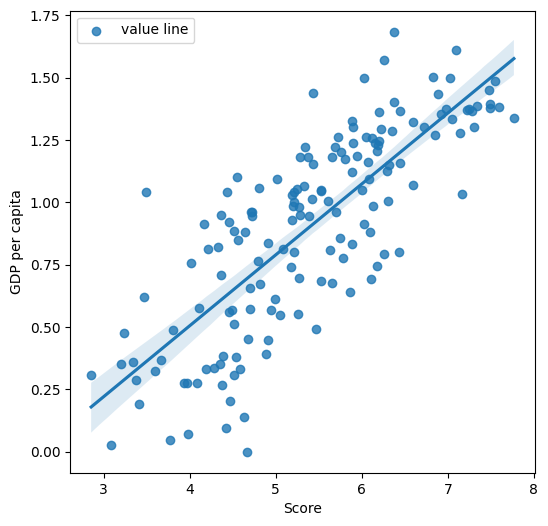

In [12]:
score = df['Score']
gdp_cap = df['GDP per capita']
plt.figure(figsize=(6, 6))
sns.regplot(x=score, y=gdp_cap, label='value line');
plt.legend(loc=2);

## Custom linear regression using gradient descent

Custom prediction function (features * Theta vector)

In [16]:
def predict(X, theta):
    prdiction = X.dot(theta)
    return prdiction

Custom cost function based on the mean square error method


In [17]:
def cost(theta, X, y):
    m = len(y)
    predictions = predict(X, theta)
    cost = np.power(predictions - y, 2).sum() / m
    return cost

Custom implementation of the gradient descent algorithm

In [18]:
def get_gradient(w, x, y):
    y_estimate = predict(x, w)
    error = y - y_estimate
    gradient = -(1.0 / len(x)) * error.T.dot(x)
    mean_squared_error = cost(w, x, y)
    return gradient, mean_squared_error

In [19]:
def gradient_descent(X, y, theta, learning_rate, n_iterations, eps, n_print):
    cost_history = []
    theta_history = []
    iterations = 1
    while True:
        gradient, error = get_gradient(theta, X, y)
        cost_history.append(error)
        new_theta = theta - learning_rate * gradient.T
        theta_history.append(new_theta)

        # Stop condition
        if np.sum(abs(theta - new_theta)) < eps:
            print("Algorithm converged.")
            break
        elif iterations == n_iterations:
            print(f"{iterations} iterations completed")
            break

        # Print error every n_print iterations
        if iterations % n_print == 0:
            print(
                f"Iteration: {iterations} - Error on train data: {round(error, 4)}"
            )

        iterations += 1
        theta = new_theta
    return theta, cost_history, theta_history, iterations

Data preparation. Splitting data into train and test samples inn 80/20 proportion. As the amount of data is insufficient, there will be no validation data.

In [20]:
X = df['GDP per capita'].values.reshape(-1, 1)
y = df['Score'].values.reshape(-1, 1)

In [21]:
test_size = 0.2
X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = True, random_state = 42)

Features scaling using sklearn MinMaxScaler.

In [22]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(X_train_df)

X_train_scaled = min_max_scaler.transform(X_train_df)
X_test_scaled = min_max_scaler.transform(X_test_df)

Adding a column with ones to both train and test samples

In [23]:
X_train_scaled_ones = np.hstack((np.ones_like(X_train_scaled), X_train_scaled))
X_test_scaled_ones = np.hstack((np.ones_like(X_test_scaled), X_test_scaled))

Launch model training with learning rate = 0.01 and n_iterations = 5000

In [24]:
theta = np.random.randn(2, 1)
learning_rate = 0.01
n_iterations = 5000
eps = 1e-5
n_print = 500

theta, cost_history, theta_history, iterations = gradient_descent(X_train_scaled_ones, y_train, theta,
                                                                  learning_rate, n_iterations, eps, n_print)

Iteration: 500 - Error on train data: 0.4842
Iteration: 1000 - Error on train data: 0.4682
Iteration: 1500 - Error on train data: 0.4583
Iteration: 2000 - Error on train data: 0.4521
Iteration: 2500 - Error on train data: 0.4482
Iteration: 3000 - Error on train data: 0.4458
Iteration: 3500 - Error on train data: 0.4443
Iteration: 4000 - Error on train data: 0.4433
Iteration: 4500 - Error on train data: 0.4427
5000 iterations completed


Plotting the cost history

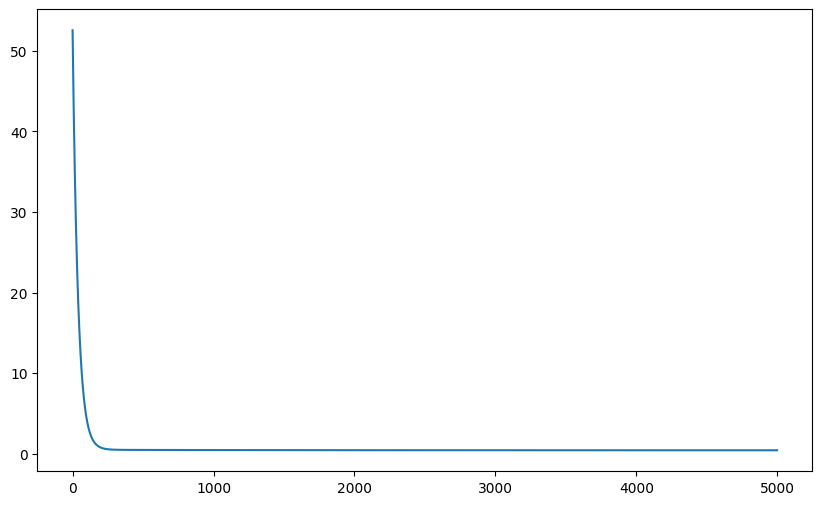

In [29]:
plt.figure(figsize=(10, 6))
Psns.lineplot(data=cost_history);

Plotting cost history of the first 200 iterations as further the model trains only a bit.

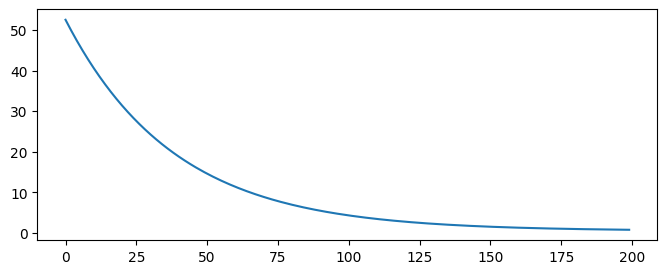

In [33]:
plt.figure(figsize=(8, 3))
sns.lineplot(data=cost_history[:200])

Print the Thetas and the final cost (MSE).

In [35]:
print('Theta0:          {:0.3f},\nTheta1:          {:0.3f},'.format(theta[0][-1],theta[1][-1]))
print('Final cost/MSE:  {:0.3f}.'.format(cost_history[-1]))

Theta0:          3.477,
Theta1:          3.610,
Final cost/MSE:  0.442.


Custom implementation of the mean squared error function

In [37]:
def my_mean_squared_error(y_true, y_predicted):
    error =  np.power(y_predicted - y_true, 2).sum() / len(y_true)
    return error

Find predictions on train and test samples and costs of the predictions on both samples.

In [39]:
train_predict = predict(X_train_scaled_ones, theta)
train_cost = my_mean_squared_error(y_train, train_predict)
print(f"Cost on train sample: {round(train_cost, 4)}")

test_predict = predict(X_test_scaled_ones, theta)
test_cost = my_mean_squared_error(y_test, test_predict)
print(f"Cost on test sample: {round(test_cost, 4)}")

Cost on train sample: 0.4423
Cost on test sample: 0.5098


Scatterplot of the 'Score' and 'GDP per capita' features with a prediction line

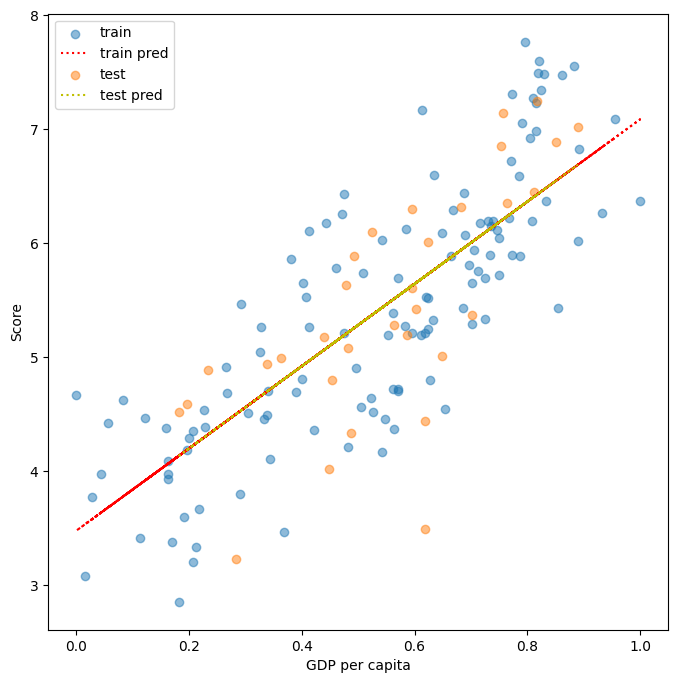

In [41]:
plt.figure(figsize=(8, 8))
plt.scatter(X_train_scaled, y_train, label='train', alpha=0.5)
plt.plot(X_train_scaled,
         train_predict,
         label='train pred',
         color='r',
         linestyle='dotted')
plt.scatter(X_test_scaled, y_test, label='test', alpha=0.5)
plt.plot(X_test_scaled,
         test_predict,
         label='test pred',
         color='y',
         linestyle='dotted')

plt.xlabel('GDP per capita')
plt.ylabel('Score')
plt.legend();

## Testing the LinearRegression function from sklearn

In [45]:
X_train_lr = pd.DataFrame(X_train_df)
X_test_lr = pd.DataFrame(X_test_df)

lr = LinearRegression()
lr.fit(X_train_lr, y_train)

LinearRegression()

Comparison of the costs of custom and sklearn linear regression on test sample

In [61]:
lr_train_predict = lr.predict(X_train_lr)
lr_test_predict = lr.predict(X_test_lr)

lr_train_mse = mean_squared_error(y_train, lr_train_predict)
lr_test_mse = mean_squared_error(y_test, lr_test_predict)

mse_train = my_mean_squared_error(y_train, train_predict)
mse_test = my_mean_squared_error(y_test, test_predict)

print(f"Train sample:\n   Custom function: {round(mse_train, 4)},\n   Sklearn: {round(lr_train_mse, 4)}.\n")
print(f"Test sample:\n   Custom function: {round(mse_test, 4)},\n   Sklearn: {round(lr_test_mse, 4)}.")

Train sample:
   Custom function: 0.4423,
   Sklearn: 0.4417.

Test sample:
   Custom function: 0.5098,
   Sklearn: 0.5079.


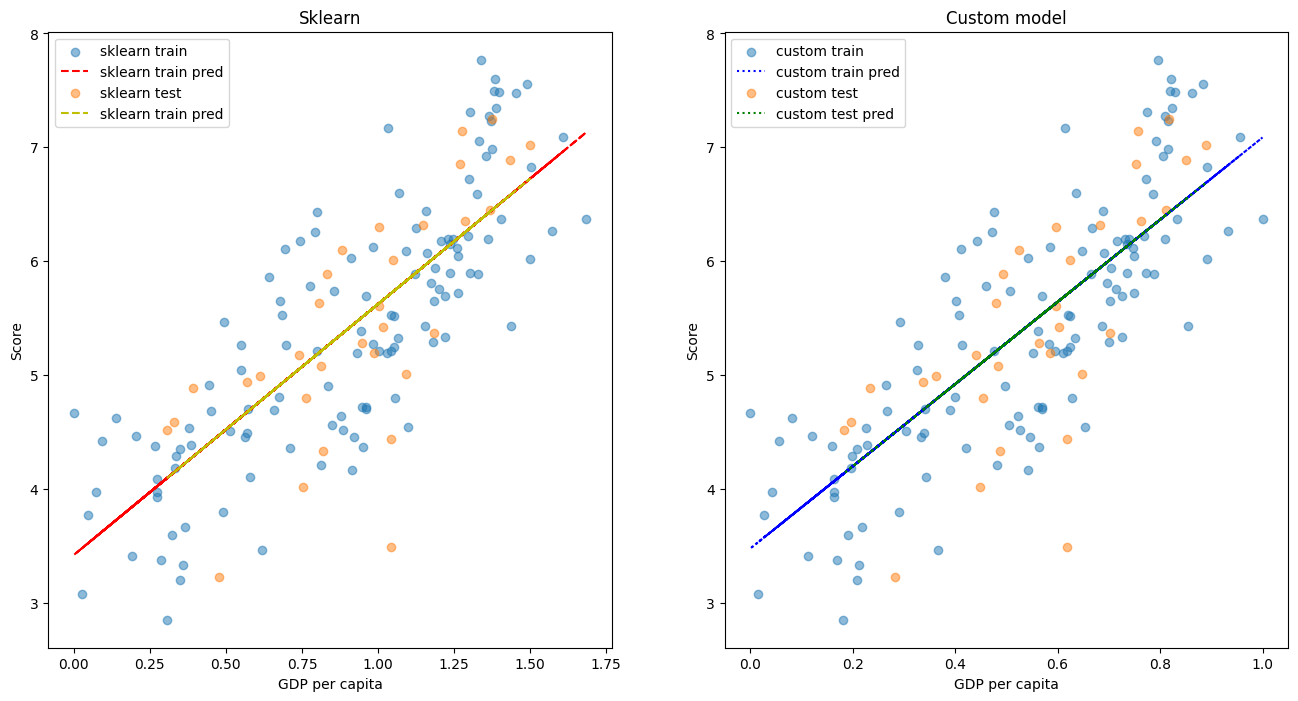

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot on the first subplot (ax1)
ax1.scatter(X_train_lr, y_train, label='sklearn train', alpha=0.5)
ax1.plot(X_train_lr[0], lr_train_predict, label='sklearn train pred', color='r', linestyle='dashed')
ax1.scatter(X_test_lr, y_test, label='sklearn test', alpha=0.5)
ax1.plot(X_test_lr[0], lr_test_predict, label='sklearn train pred', color='y', linestyle='dashed')

ax1.set_title('Sklearn')
ax1.set_xlabel('GDP per capita')
ax1.set_ylabel('Score')
ax1.legend()

# Plot on the second subplot (ax2)
ax2.scatter(X_train_scaled, y_train, label='custom train', alpha=0.5)
ax2.plot(X_train_scaled, train_predict, label='custom train pred', color='b', linestyle='dotted')
ax2.scatter(X_test_scaled, y_test, label='custom test', alpha=0.5)
ax2.plot(X_test_scaled, test_predict, label='custom test pred', color='g', linestyle='dotted')

ax2.set_title('Custom model')
ax2.set_xlabel('GDP per capita')
ax2.set_ylabel('Score')
ax2.legend();

Launch training of the sklearn LinearRegression using sample with the following features: 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption' 

In [76]:
def get_subsets(X, test_size):
    train_id, test_id = train_test_split(X.index, test_size=test_size, shuffle=True, random_state=42)
    return train_id, test_id

Data preparation

In [77]:
features = ['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 
            'Generosity', 'Perceptions of corruption']
X_1 = df[features]
y_1 = df['Score']

Getting train and test subsets

In [78]:
test_size = 0.2
train_id, test_id = get_subsets(X_1, test_size)

Data scaling

In [89]:
min_max_scaler_1 = MinMaxScaler(feature_range=(0, 1))
min_max_scaler_1.fit(X_1.loc[train_id])
min_max_scaled = min_max_scaler_1.transform(X_1)
min_max_scaled_df = pd.DataFrame(min_max_scaled, columns=X_1.columns)
min_max_scaled_df.index += 1

Model training

In [90]:
lr_1 = LinearRegression()
lr_1.fit(min_max_scaled_df.loc[train_id], y_1.loc[train_id])

LinearRegression()

Getting predictions on test and train samples

In [93]:
y_train_predict = lr_1.predict(min_max_scaled_df.loc[train_id])
y_test_predict = lr_1.predict(min_max_scaled_df.loc[test_id])

Print prediction cost on train and test samples. Comparison with the cost got in the training on 1 feature

In [94]:
mse_train_1 = mean_squared_error(y_1.loc[train_id], y_train_predict)
mse_test_1 = mean_squared_error(y_1.loc[test_id], y_test_predict)

print(f"Cost on:\n   - train sample on 1 feature: {round(lr_train_mse, 4)};") 
print(f"   - train sample on 6 features: {round(mse_train_1, 4)};") 
print(f"   - test sample on 1 feature: {round(lr_test_mse, 4)};") 
print(f"   - test sample on 6 features: {round(mse_test_1, 4)}.")

Cost on:
   - train sample on 1 feature: 0.4417;
   - train sample on 6 features: 0.2365;
   - test sample on 1 feature: 0.5079;
   - test sample on 6 features: 0.4145.


Thetas

In [95]:
pd.DataFrame(data=lr_1.coef_, index=X_1.columns, columns=['Thetas']).sort_values('Thetas', ascending=False)

,Thetas
Social support,2.001295
GDP per capita,1.264207
Healthy life expectancy,1.062208
Freedom to make life choices,0.940072
Perceptions of corruption,0.503931
Generosity,0.153034


## Testing the Polinomial Regression model

Function to get the model quality metrics

In [96]:
def get_metrics(y_true, y_predicted):
    mse = mean_squared_error(y_true=y_true, y_pred=y_predicted)
    r2 = r2_score(y_true=y_true, y_pred=y_predicted)
    return dict(mse=mse, r2=r2)

Training function

In [97]:
def poly_reg(X, y, degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    X_train_poly = polynomial_features.fit_transform(X.loc[train_id])
    X_test_poly = polynomial_features.fit_transform(X.loc[test_id])

    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y.loc[train_id])
    
    poly_train_predict = poly_model.predict(X_train_poly)
    poly_test_predict = poly_model.predict(X_test_poly)
    
    return poly_train_predict, poly_test_predict, poly_model  

Train model and print metrics

In [98]:
degree = 2
poly_train_predict, poly_test_predict, poly_model = poly_reg(min_max_scaled_df, y_1, degree)

In [100]:
train_metrics = get_metrics(y_1.loc[train_id], poly_train_predict)
test_metrics = get_metrics(y_1.loc[test_id], poly_test_predict)

In [101]:
print(f"Train subset: mse={train_metrics['mse']}, r2={train_metrics['r2']}")
print(f"Test subset: mse={test_metrics['mse']}, r2={test_metrics['r2']}")

Train subset: mse=0.2086761110761089, r2=0.8369030285825898
Test subset: mse=0.38134354809570314, r2=0.6335783770632585


## Testing the model based on found hyperparams using GridSearchCV

Create pipeline consisting of the following steps: MinMaxScaler, PolynomialFeatures and ElasticNet.

In [103]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                     ('polynomial_features', PolynomialFeatures()),
                     ('model', ElasticNet())])

Searching hyperparams

In [104]:
param_grid = {
    'polynomial_features__degree': np.arange(2, 5, 1),
    'model__alpha': np.arange(0.0001, 0.8, 0.1),
    'model__l1_ratio': np.arange(0.1, 1, 0.2),
    'model__fit_intercept': [True, False]
}

search = GridSearchCV(pipeline,
                      param_grid,
                      cv=5,
                      scoring="neg_mean_squared_error",
                      verbose=0)

In [105]:
warnings.filterwarnings("ignore", message="Objective did not converge")
search.fit(X_1.loc[train_id], y_1.loc[train_id])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('polynomial_features',
                                        PolynomialFeatures()),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': array([1.000e-04, 1.001e-01, 2.001e-01, 3.001e-01, 4.001e-01, 5.001e-01,
       6.001e-01, 7.001e-01]),
                         'model__fit_intercept': [True, False],
                         'model__l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                         'polynomial_features__degree': array([2, 3, 4])},
             scoring='neg_mean_squared_error')

In [106]:
search.best_params_

{'model__alpha': 0.10010000000000001,
 'model__fit_intercept': True,
 'model__l1_ratio': 0.1,
 'polynomial_features__degree': 4}

Get predictions based on the found model on test sample

In [108]:
best_model=search.best_estimator_

test_cv_prediction = best_model.predict(X_1.loc[test_id])
cv_metrics = get_metrics(y_1.loc[test_id], test_cv_prediction)

In [109]:
poli_metrics = get_metrics(y_1.loc[test_id], poly_test_predict)

In [113]:
print(
    f"Linear regression (mse):\n   Custom: {round(
        mse_test, 4)},\n   Sklearn: {round(lr_test_mse, 4)}\n"
)
print(
    f"Polinomial regression with features degree=2:\n   mse = {
        round(poli_metrics['mse'], 4)}\n   r2 = {round(poli_metrics['r2'], 4)}\n"
)
print(
    f"Model based on hyperparams:\n   mse = {
        cv_metrics['mse']}\n   r2 = {cv_metrics['r2']}"
)

Linear regression (mse):
   Custom: 0.5098,
   Sklearn: 0.5079

Polinomial regression with features degree=2:
   mse = 0.3813
   r2 = 0.6336

Model based on hyperparams:
   mse = 0.3228840406341879
   r2 = 0.689750371337448
